In [1]:
import os
import cv2
import math
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from tqdm import tqdm
from pathlib import Path
import torch.optim as optim
from torchinfo import summary
from datetime import timedelta
from functools import lru_cache
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from torchvision.models import Inception_V3_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dataset = Path(r"/kaggle/input/")
covid_19 = dataset / "covid19-radiography-database" / "COVID-19_Radiography_Dataset"
chest_xray = dataset / "chest-xray-pneumonia" / "chest_xray"
tb_chest = dataset / "tuberculosis-tb-chest-xray-dataset" / "TB_Chest_Radiography_Database"

In [4]:
class_mapping = defaultdict(list)

def append_file_names(directory, cls_name):
    """
    Append file names from a given directory to the corresponding class in the class_mapping dictionary.

    Args:
        directory (str): Directory path.
        cls_name (str): Name of the class.
    """
    for f_name in os.listdir(directory):
        if f_name.endswith((".jpeg", ".png")):
            class_mapping[cls_name].append(os.path.join(directory, f_name))

In [5]:
for covid19_class in [entry.name for entry in os.scandir(covid_19) if entry.is_dir()]:
    append_file_names(covid_19 / f"{covid19_class}" / 'images', f"{covid19_class}")

In [6]:
pneumonia_dirs = [chest_xray / "train" / "PNEUMONIA",
                  chest_xray / "test" / "PNEUMONIA",
                  chest_xray / "val" / "PNEUMONIA"]
for source_dir in pneumonia_dirs:
    for filename in os.listdir(source_dir):
        if filename.endswith(".jpeg"):
            if "bacteria" in filename:
                class_mapping["Bacterial Pneumonia"].append(os.path.join(source_dir, filename))

In [7]:
append_file_names(tb_chest / "Tuberculosis", "Tuberculosis")

In [8]:
class_names = list(class_mapping.keys())
image_paths = []
labels = []

for class_name, file_paths in class_mapping.items():
    for file_path in tqdm(file_paths, desc=f"Processing {class_name}"):
        image_paths.append(file_path)
        labels.append(class_name)

Processing Tuberculosis: 100%|██████████| 700/700 [00:00<00:00, 2107690.45it/s]


In [9]:
def is_black_and_white(image):
    """
    Check if the given image is black and white (grayscale).

    Parameters:
        image (PIL.Image.Image): The image object to check.

    Returns:
        bool: True if the image is black and white, False otherwise.
    """
    return image.mode == 'L'

In [10]:
from concurrent.futures import ThreadPoolExecutor
from PIL import Image

In [11]:
def process_image(image_path, label):
    """
    Process a single image and return the color type.

    Parameters:
        image_path (str): File path of the image.
        label: Class label of the image.

    Returns:
        tuple: A tuple containing the label and color type ('Black & White' or 'Colored').
    """
    with Image.open(image_path) as image:
        color_type = 'Black & White' if is_black_and_white(image) else 'Colored'
    return label, color_type

def count_images_per_class(image_paths, labels):
    """
    Count the number of black and white and colored images per class.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.

    Returns:
        pandas.DataFrame: DataFrame containing the counts per class in tabular format.
    """
    data = defaultdict(lambda: {'Black & White': 0, 'Colored': 0})

    with ThreadPoolExecutor() as executor:
        processed_results = list(tqdm(executor.map(process_image, image_paths, labels), total=len(image_paths), desc="Processing images"))

    for label, color_type in processed_results:
        data[label][color_type] += 1

    df = pd.DataFrame(data).transpose().reset_index()
    df = df.rename(columns={'index': 'Class'})
    return df

result_df = count_images_per_class(image_paths, labels)
print(result_df)

Processing images: 100%|██████████| 24645/24645 [00:23<00:00, 1038.68it/s]

                 Class  Black & White  Colored
0               Normal          10192        0
1         Lung_Opacity           6012        0
2      Viral Pneumonia           1205      140
3                COVID           3616        0
4  Bacterial Pneumonia           2637      143
5         Tuberculosis            308      392


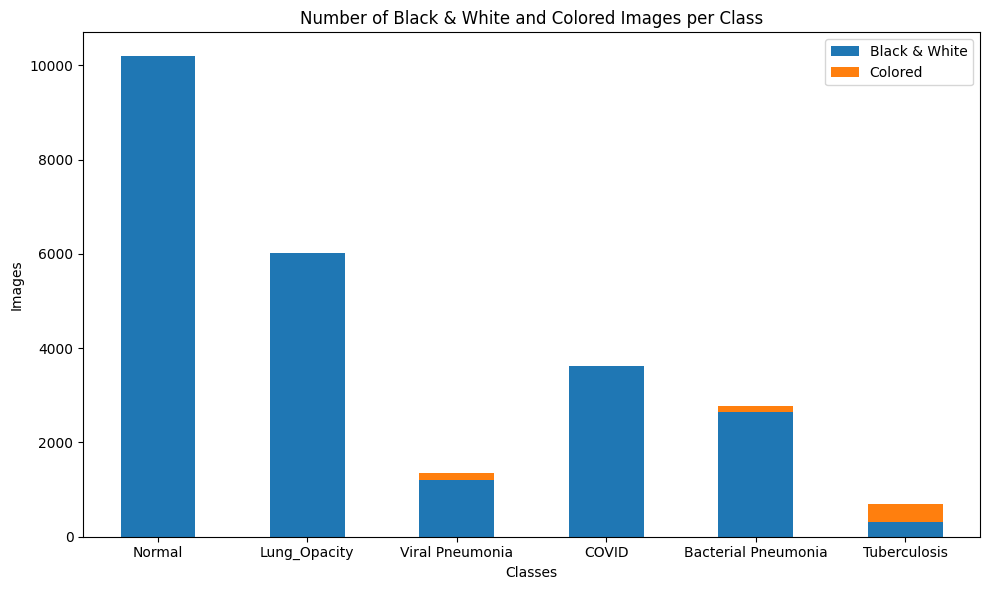

In [12]:
def visualize_images_per_class(result_df, class_column='Class', bw_column='Black & White', colored_column='Colored'):
    """
    Visualize the number of black and white images and colored images per class.

    Parameters:
        result_df (pandas.DataFrame): DataFrame containing the counts per class.
        class_column (str): Name of the column containing the class labels.
        bw_column (str): Name of the column containing the count of black and white images.
        colored_column (str): Name of the column containing the count of colored images.

    Returns:
        None
    """
    result_df.set_index(class_column, inplace=True)

    ax = result_df.plot(kind='bar', stacked=True, figsize=(10, 6), rot=0)
    ax.set_xlabel('Classes')
    ax.set_ylabel('Images')
    ax.set_title('Number of Black & White and Colored Images per Class')
    ax.legend(["Black & White", "Colored"])

    plt.tight_layout()
    plt.show()

visualize_images_per_class(result_df)

Loading and displaying images: 100%|██████████| 6/6 [00:00<00:00, 194.00it/s]


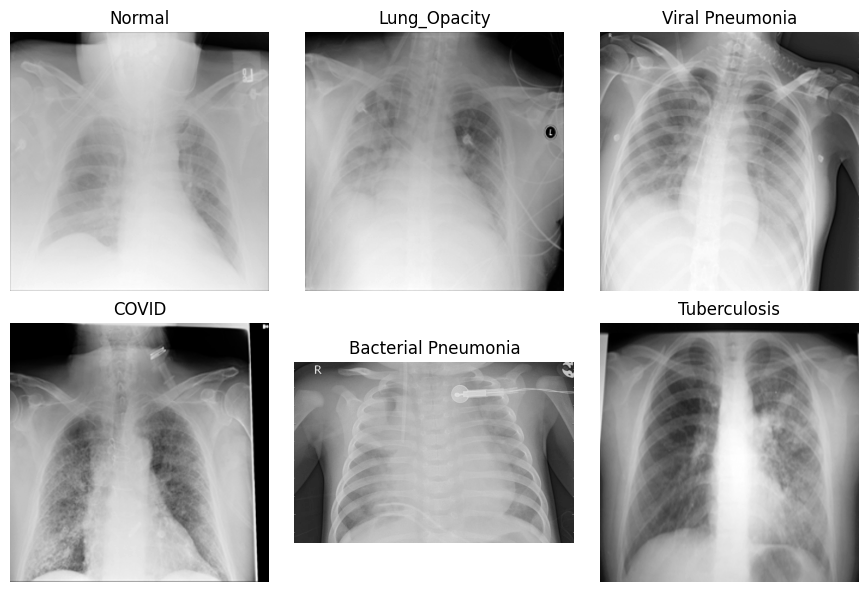

In [13]:
def group_images_by_class(image_paths, labels):
    """
    Group image paths by class label.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.

    Returns:
        dict: A dictionary where the keys are class labels, and the values are lists of image paths for each class.
    """
    class_to_images = {}
    for img_path, label in zip(image_paths, labels):
        if label not in class_to_images:
            class_to_images[label] = []
        class_to_images[label].append(img_path)
    return class_to_images

def display_images_per_class(image_paths, labels):
    class_to_images = group_images_by_class(image_paths, labels)
    num_classes = len(class_to_images)

    num_rows, num_cols = 1, num_classes
    if num_classes == 4:
        num_rows, num_cols = 2, 2
    elif num_classes == 6:
        num_rows, num_cols = 2, 3

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))

    with tqdm(total=num_classes, desc="Loading and displaying images") as pbar:
        for i, (class_label, image_paths_for_class) in enumerate(class_to_images.items()):
            selected_image_path = random.choice(image_paths_for_class)
            try:
                selected_image = Image.open(selected_image_path)
                ax = axs[i // num_cols, i % num_cols]
                ax.imshow(selected_image, cmap='gray')
                ax.set_title(class_label)
                ax.axis('off')
            except Exception as e:
                print(f"Error loading image: {selected_image_path}")
                print(e)

            pbar.update(1)

    plt.tight_layout()
    plt.show()

display_images_per_class(image_paths, labels)

Displaying Images: 100%|██████████| 6/6 [00:28<00:00,  4.71s/it]


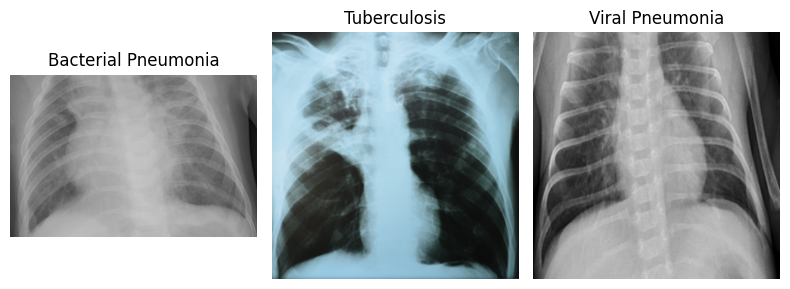

In [14]:
@lru_cache(maxsize=100)
def load_colored_image(image_path):
    """
    Load an image using Pillow and check if it is a colored image (not grayscale).

    Parameters:
        image_path (str): The path to the image file.

    Returns:
        numpy.ndarray or None: The loaded colored image as a NumPy array, or None if grayscale.
    """
    try:
        img = Image.open(image_path)
        if not is_black_and_white(img):
            return np.array(img)
    except (IOError, OSError) as e:
        raise Exception(f"Error loading image '{image_path}': {e}")
    return None

def display_colored_images(image_paths, labels, num_images_per_class=1):
    """
    Randomly display colored images for each class.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.
        num_images_per_class (int): Number of images to display per class.

    Returns:
        None
    """
    plt.figure(figsize=(8, 6))
    displayed_classes = 0
    unique_labels = set(labels)

    shuffled_labels = list(unique_labels)
    random.shuffle(shuffled_labels)

    for class_label in tqdm(shuffled_labels, desc="Displaying Images"):
        image_paths_for_class = [img_path for img_path, lbl in zip(image_paths, labels) if lbl == class_label]
        colored_images_for_class = [img_path for img_path in image_paths_for_class if load_colored_image(img_path) is not None]

        if len(colored_images_for_class) == 0:
            continue

        num_images_to_display = min(len(colored_images_for_class), num_images_per_class)

        for i in range(num_images_to_display):
            selected_image_path = random.choice(colored_images_for_class)
            selected_image = load_colored_image(selected_image_path)

            displayed_classes += 1
            plt.subplot(2, 3, displayed_classes)
            plt.imshow(selected_image)
            plt.title(f"{class_label}")
            plt.axis('off')

            if displayed_classes == 6:
                break

        if displayed_classes == 6:
            break

    plt.tight_layout()
    plt.show()

display_colored_images(image_paths, labels, num_images_per_class=1)

In [15]:
# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
classes = label_encoder.classes_
num_classes = len(classes)

# First: split off the test set (10% of the total)
remaining_paths, test_paths, remaining_labels, test_labels = train_test_split(
    image_paths,
    labels_encoded,
    test_size=0.3207835156,
    random_state=42,
    stratify=labels_encoded
)

# Second: from the remaining 90%, split off the validation set.
# To have validation = 10% of the total, we use test_size = 0.1 / 0.9 ≈ 0.1111 here.
train_paths, val_paths, train_labels, val_labels = train_test_split(
    remaining_paths,
    remaining_labels,
    test_size=0.2,
    random_state=42,
    stratify=remaining_labels
)

# Calculate total counts and percentages
total_samples = len(labels_encoded)
total_train_samples = len(train_paths)
total_val_samples = len(val_paths)
total_test_samples = len(test_paths)

train_percentage = (total_train_samples / total_samples) * 100
val_percentage = (total_val_samples / total_samples) * 100
test_percentage = (total_test_samples / total_samples) * 100

# Compute class distribution counts for each split
train_counts = pd.Series(train_labels).value_counts().sort_index()
val_counts = pd.Series(val_labels).value_counts().sort_index()
test_counts = pd.Series(test_labels).value_counts().sort_index()

# Create DataFrames for reporting (assuming 'class_names' is defined)
train_df = pd.DataFrame({'Train Samples': train_counts})
val_df = pd.DataFrame({'Validation Samples': val_counts})
test_df = pd.DataFrame({'Test Samples': test_counts})
train_df.index = val_df.index = test_df.index = class_names

# Print summary information
print("Total Train Samples:", total_train_samples)
print("Total Validation Samples:", total_val_samples)
print("Total Test Samples:", total_test_samples)
print("\nPercentage of Split:")
print("Train: {:.2f}%".format(train_percentage))
print("Validation: {:.2f}%".format(val_percentage))
print("Test: {:.2f}%".format(test_percentage))
print("\nClass Distribution:")
result_df = pd.concat([train_df, val_df, test_df], axis=1)
print(result_df)

Total Train Samples: 13391
Total Validation Samples: 3348
Total Test Samples: 7906

Percentage of Split:
Train: 54.34%
Validation: 13.58%
Test: 32.08%

Class Distribution:
                     Train Samples  Validation Samples  Test Samples
Normal                        1511                 377           892
Lung_Opacity                  1965                 491          1160
Viral Pneumonia               3266                 817          1929
COVID                         5538                1385          3269
Bacterial Pneumonia            380                  95           225
Tuberculosis                   731                 183           431


In [16]:
class ImageDataset(Dataset):
    def __init__(self, img_paths, img_labels, transform=None):
        """
        Custom Dataset class to load and preprocess images.

        Args:
            img_paths (list): List of image file paths.
            img_labels (list): List of corresponding image labels.
            transform (callable, optional): Transform to apply to images. Defaults to None.
        """
        self.img_paths = img_paths
        self.img_labels = img_labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img = cv2.imread(str(self.img_paths[index]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        pil_img = Image.fromarray(img)
        
        transformed_img = self.transform(pil_img)

        label = self.img_labels[index]
        return transformed_img, label

In [17]:
BATCH_SIZE = 8

transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.RandomAffine(
        degrees=10,          # rotation range: 10 degrees
        translate=(0.1, 0.1),  # width and height shift range: 0.1
        scale=(0.8, 1.2)       # zoom range: 0.2 (i.e., 20% variation)
    ),
    transforms.ToTensor(),
])

train_dataset = ImageDataset(train_paths, train_labels, transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

val_dataset = ImageDataset(val_paths, val_labels, transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

test_dataset = ImageDataset(test_paths, test_labels, transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

train_steps = len(train_loader)
val_steps = len(val_loader)
test_steps = len(test_loader)

In [18]:
class InceptionV3CustomModel(nn.Module):
    def __init__(self, pretrained=True, dropout_rate=0.5):
        super().__init__()
        # Load pretrained InceptionV3 with aux_logits enabled (required for weights)
        # then disable auxiliary logits for the forward pass.
        if pretrained:
            inception = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
            inception.aux_logits = False
        else:
            inception = models.inception_v3(weights=None, aux_logits=False)
        
        # Build the feature extractor using layers up to Mixed_7c.
        self.features = nn.Sequential(
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
            inception.Conv2d_3b_1x1,
            inception.Conv2d_4a_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
            inception.Mixed_5b,
            inception.Mixed_5c,
            inception.Mixed_5d,
            inception.Mixed_6a,
            inception.Mixed_6b,
            inception.Mixed_6c,
            inception.Mixed_6d,
            inception.Mixed_6e,
            inception.Mixed_7a,
            inception.Mixed_7b,
            inception.Mixed_7c,
        )
        
        # Global max pooling: (B, 2048, 10, 10) → (B, 2048, 1, 1)
        self.global_max_pool = nn.AdaptiveMaxPool2d(1)
        
        # Fully connected layer: reduces features from 2048 to 128.
        self.fc = nn.Linear(2048, 128)
        self.dropout = nn.Dropout(p=dropout_rate)
    
    def forward(self, x):
        # Extract features from the input.
        x = self.features(x)
        # Apply global max pooling.
        x = self.global_max_pool(x)
        # Flatten the tensor: (B, 2048, 1, 1) → (B, 2048)
        x = torch.flatten(x, 1)
        # Fully connected layer and dropout.
        x = self.fc(x)
        x = self.dropout(x)
        return x

In [19]:
class ConvDropConv(nn.Module):
    """
    A helper module that performs:
    1x1 convolution → dropout → convolution (with specified kernel parameters).
    """
    def __init__(self, in_channels, hidden_channels, out_channels, kernel_size, stride, padding, dropout_rate=0.5):
        super(ConvDropConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=1, stride=1, padding=0)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.conv2 = nn.Conv2d(hidden_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        return x

class PoolConv(nn.Module):
    """
    A helper module for average pooling followed by a 1x1 convolution.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(PoolConv, self).__init__()
        self.pool = nn.AvgPool2d(kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
    
    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        return x

class InceptionBlock(nn.Module):
    """
    A generic Inception-style downsampling block with four branches:
      - Branch 1: 1x1 conv with stride 2.
      - Branch 2: 1x1 conv → dropout → convolution.
      - Branch 3: 1x1 conv → dropout → convolution.
      - Branch 4: Average pooling → 1x1 conv.
    The branch outputs are concatenated along the channel dimension.
    """
    def __init__(self, in_channels, 
                 branch1_out,
                 branch2_hidden, branch2_out, branch2_kernel, branch2_padding,
                 branch3_hidden, branch3_out, branch3_kernel, branch3_padding,
                 branch4_out, dropout_rate=0.5):
        super(InceptionBlock, self).__init__()
        # Branch 1: 1x1 conv with stride 2.
        self.branch1 = nn.Conv2d(in_channels, branch1_out, kernel_size=1, stride=2, padding=0)
        # Branch 2: 1x1 conv → dropout → conv with specified kernel parameters.
        self.branch2 = ConvDropConv(in_channels, branch2_hidden, branch2_out, 
                                    kernel_size=branch2_kernel, stride=2, padding=branch2_padding,
                                    dropout_rate=dropout_rate)
        # Branch 3: 1x1 conv → dropout → conv with specified kernel parameters.
        self.branch3 = ConvDropConv(in_channels, branch3_hidden, branch3_out, 
                                    kernel_size=branch3_kernel, stride=2, padding=branch3_padding,
                                    dropout_rate=dropout_rate)
        # Branch 4: Average pooling → 1x1 conv.
        self.branch4 = PoolConv(in_channels, branch4_out, kernel_size=3, stride=2, padding=1)
    
    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        b4 = self.branch4(x)
        return torch.cat([b1, b2, b3, b4], dim=1)

class CustomInceptionModuleDownsample(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CustomInceptionModuleDownsample, self).__init__()
        # Block 1: Downsample from 384x384 → 192x192, output channels = 128.
        # Branch outputs: 32, 32, 16, and 48 channels respectively.
        self.block1 = InceptionBlock(in_channels=3,
                                     branch1_out=32,
                                     branch2_hidden=32, branch2_out=32, branch2_kernel=3, branch2_padding=1,
                                     branch3_hidden=32, branch3_out=16, branch3_kernel=5, branch3_padding=2,
                                     branch4_out=48,
                                     dropout_rate=dropout_rate)
        # Block 2: Downsample from 192x192 → 96x96, output channels = 64.
        # Branch outputs: 16, 16, 8, and 24 channels respectively.
        self.block2 = InceptionBlock(in_channels=128,
                                     branch1_out=16,
                                     branch2_hidden=16, branch2_out=16, branch2_kernel=3, branch2_padding=1,
                                     branch3_hidden=16, branch3_out=8, branch3_kernel=5, branch3_padding=2,
                                     branch4_out=24,
                                     dropout_rate=dropout_rate)
        # Block 3: Downsample from 96x96 → 48x48, output channels = 32.
        # Branch outputs: 8, 8, 4, and 12 channels respectively.
        self.block3 = InceptionBlock(in_channels=64,
                                     branch1_out=8,
                                     branch2_hidden=8, branch2_out=8, branch2_kernel=3, branch2_padding=1,
                                     branch3_hidden=8, branch3_out=4, branch3_kernel=5, branch3_padding=2,
                                     branch4_out=12,
                                     dropout_rate=dropout_rate)
    
    def forward(self, x):
        # Assume input x shape is (B, 3, 384, 384)
        out1 = self.block1(x)   # → (B, 128, 192, 192)
        out2 = self.block2(out1)  # → (B, 64, 96, 96)
        out3 = self.block3(out2)  # → (B, 32, 48, 48)
        return out3

In [20]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=32, patch_size=8, embed_dim=16):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.conv = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        """
        Input: (batch, 32, 48, 48)
        Output: (batch, num_patches, embed_dim), where num_patches = 48//patch_size * 48//patch_size
        """
        x = self.conv(x)  # (batch, embed_dim, num_patches_h, num_patches_w)
        x = x.flatten(2)  # (batch, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (batch, num_patches, embed_dim)
        return x

class CustomTransformerLayer(nn.Module):
    def __init__(self, embed_dim=16, num_heads=4, dropout_rate=0.1):
        super(CustomTransformerLayer, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout_rate, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        
        self.fc1 = nn.Linear(embed_dim, 32)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(32, embed_dim)
        self.dropout2 = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        # Skip connection 1 (input to add)
        x_norm1 = self.norm1(x)
        attn_output, _ = self.mha(x_norm1, x_norm1, x_norm1)
        x = x + attn_output  # Add skip connection
        
        # Skip connection 2 (add to add before output)
        x_norm2 = self.norm2(x)
        fc_output = self.fc1(x_norm2)
        fc_output = F.relu(fc_output)
        fc_output = self.dropout1(fc_output)
        fc_output = self.fc2(fc_output)
        fc_output = self.dropout2(fc_output)
        
        output = x + fc_output  # Add skip connection
        return output

class GlobalAvgPoolingModel(nn.Module):
    def __init__(self, in_channels=32, dropout_rate=0.5):
        super(GlobalAvgPoolingModel, self).__init__()
        # Global average pooling along the last dimension.
        # Input is assumed to have shape (batch, in_channels, L) and this layer
        # outputs shape (batch, in_channels, 1)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        
        # Map pooled features to the desired 16-dimensional vector.
        self.fc0 = nn.Linear(in_channels, 16)
        
        # Then follow the specified pipeline:
        # 16 -> dropout -> dense (16 to 256) -> dropout -> dense (256 to 128) -> dropout
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(16, 256)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        # x shape: (batch, in_channels, L)
        x = self.global_avg_pool(x)  # Shape: (batch, in_channels, 1)
        x = x.squeeze(-1)            # Shape: (batch, in_channels)
        x = self.fc0(x)              # Map to (batch, 16)
        x = self.dropout1(x)
        x = self.fc1(x)              # Shape: (batch, 256)
        x = self.dropout2(x)
        x = self.fc2(x)              # Shape: (batch, 128)
        x = self.dropout3(x)
        return x

In [21]:
class LocalBranch(nn.Module):
    def __init__(self, dropout_rate=0.5, num_transformer_layers=2):
        super(LocalBranch, self).__init__()
        
        # Step 1: Custom Inception Module Downsample
        self.inception_downsample = CustomInceptionModuleDownsample(dropout_rate=dropout_rate)
        
        # Step 2: Patch Embedding
        self.patch_embedding = PatchEmbedding(in_channels=32, patch_size=8, embed_dim=16)
        
        # Step 3: Transformer Layers
        self.transformer_layers = nn.Sequential(
            *[CustomTransformerLayer(embed_dim=16, num_heads=4, dropout_rate=dropout_rate) 
              for _ in range(num_transformer_layers)]
        )
        
        # Additional normalization layer after the last transformer layer.
        # It normalizes over the embedding dimension of size 16.
        self.final_norm = nn.LayerNorm(16)
        
        # Step 4: Global Average Pooling Model
        self.global_avg_pooling = GlobalAvgPoolingModel(in_channels=16, dropout_rate=dropout_rate)
    
    def forward(self, x):
        # Step 1: Inception Downsampling
        x = self.inception_downsample(x)  # Output shape: (batch, 32, 48, 48)
        
        # Step 2: Patch Embedding
        x = self.patch_embedding(x)  # Output shape: (batch, num_patches, 16)
        
        # Step 3: Transformer Layers
        x = self.transformer_layers(x)  # Output shape remains (batch, num_patches, 16)

        # Apply normalization before global pooling
        x = self.final_norm(x)  # (B, num_patches, 16)
        
        # Step 4: Global Average Pooling
        x = x.permute(0, 2, 1)  # Convert to (batch, 16, num_patches) for pooling
        x = self.global_avg_pooling(x)  # Output shape: (batch, 128)
        
        return x

In [22]:
class InceptionTransformer(nn.Module):
    def __init__(self, num_classes=9, dropout_rate=0.5, num_transformer_layers=8, pretrained=True):
        super(InceptionTransformer, self).__init__()
        # Global branch from InceptionV3
        self.global_branch = InceptionV3CustomModel(pretrained=pretrained, dropout_rate=dropout_rate)
        # Local branch that includes downsampling, patch embedding, transformer layers, and global pooling
        self.local_branch = LocalBranch(dropout_rate=dropout_rate, num_transformer_layers=num_transformer_layers)
        
        # After concatenation, we have 128 (global) + 128 (local) = 256 features.
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        # x: (batch, 3, 384, 384)
        global_feat = self.global_branch(x)  # (batch, 128)
        local_feat = self.local_branch(x)      # (batch, 128)
        
        # Concatenate features from both branches to form a 256-d vector.
        combined = torch.cat([global_feat, local_feat], dim=1)  # (batch, 256)
        
        # Feed through the classification head.
        x = self.dropout(combined)
        x = F.relu(self.fc1(x))  # (batch, 64)
        x = self.dropout(x)
        x = F.relu(self.fc2(x))  # (batch, 32)
        x = self.dropout(x)
        x = self.fc3(x)          # (batch, 9) → logits for 9 classes
        return x

In [23]:
model = InceptionTransformer(num_classes=6, dropout_rate=0.5, num_transformer_layers=8, pretrained=True)
model.to(device)
summary(model, (1, 3, 384, 384))

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 167MB/s]  


Layer (type:depth-idx)                             Output Shape              Param #
InceptionTransformer                               [1, 6]                    --
├─InceptionV3CustomModel: 1-1                      [1, 128]                  --
│    └─Sequential: 2-1                             [1, 2048, 10, 10]         --
│    │    └─BasicConv2d: 3-1                       [1, 32, 191, 191]         928
│    │    └─BasicConv2d: 3-2                       [1, 32, 189, 189]         9,280
│    │    └─BasicConv2d: 3-3                       [1, 64, 189, 189]         18,560
│    │    └─MaxPool2d: 3-4                         [1, 64, 94, 94]           --
│    │    └─BasicConv2d: 3-5                       [1, 80, 94, 94]           5,280
│    │    └─BasicConv2d: 3-6                       [1, 192, 92, 92]          138,624
│    │    └─MaxPool2d: 3-7                         [1, 192, 45, 45]          --
│    │    └─InceptionA: 3-8                        [1, 256, 45, 45]          255,904
│    │    └─In

In [24]:
def custom_metrics(y_pred, y_true, loss):
    """
    Calculate custom evaluation metrics for multiclass classification.

    Args:
        y_pred (Tensor): Predicted probabilities for each class.
        y_true (Tensor): True labels.
        loss (float): Loss value.

    Returns:
        dict: Dictionary containing computed metrics.
    """
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted')

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    
    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()
        auc_score = roc_auc_score(class_y_true, class_y_pred)
        auc_scores.append(auc_score)

    auc_avg = np.mean(auc_scores)

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.00001)

In [26]:
# Metrics initialization
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric_name: [] for metric_name in metric_names}
val_metrics_history = {metric_name: [] for metric_name in metric_names}

num_epochs = 25
total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Model - Epoch [{epoch + 1}/{num_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())
    
    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time
    
    average_loss = total_loss / len(train_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    training_metrics_line = "Metrics - "
    for metric_name, metric_value in train_metrics.items():
        if metric_name == 'auc':
            training_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            training_metrics_line += f"{metric_name}: {metric_value:.4f}, "
    print(training_metrics_line)
    
    for metric_name in metric_names:
        train_metrics_history[metric_name].append(train_metrics[metric_name])
    
    # Validation loop
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    start_time = time.time()
    
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model: ")):
            data = data.to(device)
            targets = targets.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            all_predictions.extend(outputs.detach().cpu().numpy())
            all_targets.extend(targets.detach().cpu().numpy())
    
    end_time = time.time()
    epoch_validation_time = end_time - start_time
    total_validation_time += epoch_validation_time
    
    average_loss = total_loss / len(val_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    validation_metrics_line = "Metrics - "
    for metric_name, metric_value in val_metrics.items():
        if metric_name == 'auc':
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}, "
    print(validation_metrics_line)
    
    for metric_name in metric_names:
        val_metrics_history[metric_name].append(val_metrics[metric_name])

print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

avg_training_time_per_epoch = total_training_time / num_epochs
avg_validation_time_per_epoch = total_validation_time / num_epochs
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Model - Epoch [1/25]: 100%|██████████| 1674/1674 [05:34<00:00,  5.00it/s]


Metrics - loss: 1.3685, accuracy: 0.4578, precision: 0.3927, recall: 0.4578, f1_score: 0.4138, specificity: 0.1873, sensitivity: 0.9546, mcc: 0.2082, auc: 0.6598


Validating Model: 100%|██████████| 419/419 [00:22<00:00, 18.80it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9228, accuracy: 0.6998, precision: 0.6446, recall: 0.6998, f1_score: 0.6454, specificity: 0.8833, sensitivity: 0.9108, mcc: 0.5856, auc: 0.8057


Training Model - Epoch [2/25]: 100%|██████████| 1674/1674 [05:34<00:00,  5.00it/s]


Metrics - loss: 0.9640, accuracy: 0.6692, precision: 0.5952, recall: 0.6692, f1_score: 0.6262, specificity: 0.7935, sensitivity: 0.9476, mcc: 0.5332, auc: 0.8035


Validating Model: 100%|██████████| 419/419 [00:21<00:00, 19.51it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.6821, accuracy: 0.7817, precision: 0.7170, recall: 0.7817, f1_score: 0.7464, specificity: 0.9973, sensitivity: 0.9795, mcc: 0.6960, auc: 0.8742


Training Model - Epoch [3/25]: 100%|██████████| 1674/1674 [05:34<00:00,  5.01it/s]


Metrics - loss: 0.7678, accuracy: 0.7437, precision: 0.6959, recall: 0.7437, f1_score: 0.7132, specificity: 0.8756, sensitivity: 0.9728, mcc: 0.6433, auc: 0.8532


Validating Model: 100%|██████████| 419/419 [00:21<00:00, 19.24it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.4461, accuracy: 0.8408, precision: 0.7851, recall: 0.8408, f1_score: 0.8081, specificity: 0.9841, sensitivity: 0.9983, mcc: 0.7831, auc: 0.9445


Training Model - Epoch [4/25]: 100%|██████████| 1674/1674 [05:34<00:00,  5.00it/s]


Metrics - loss: 0.6131, accuracy: 0.7943, precision: 0.7666, recall: 0.7943, f1_score: 0.7645, specificity: 0.9398, sensitivity: 0.9811, mcc: 0.7170, auc: 0.8824


Validating Model: 100%|██████████| 419/419 [00:22<00:00, 18.81it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.4850, accuracy: 0.8330, precision: 0.7667, recall: 0.8330, f1_score: 0.7979, specificity: 1.0000, sensitivity: 0.9724, mcc: 0.7703, auc: 0.9283


Training Model - Epoch [5/25]: 100%|██████████| 1674/1674 [05:33<00:00,  5.01it/s]


Metrics - loss: 0.5852, accuracy: 0.8105, precision: 0.7825, recall: 0.8105, f1_score: 0.7889, specificity: 0.9173, sensitivity: 0.9721, mcc: 0.7392, auc: 0.8878


Validating Model: 100%|██████████| 419/419 [00:22<00:00, 18.93it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.4605, accuracy: 0.8533, precision: 0.8293, recall: 0.8533, f1_score: 0.8372, specificity: 0.9920, sensitivity: 0.9670, mcc: 0.7982, auc: 0.9233


Training Model - Epoch [6/25]: 100%|██████████| 1674/1674 [05:33<00:00,  5.01it/s]


Metrics - loss: 0.4936, accuracy: 0.8518, precision: 0.8531, recall: 0.8518, f1_score: 0.8366, specificity: 0.9497, sensitivity: 0.9787, mcc: 0.7959, auc: 0.9018


Validating Model: 100%|██████████| 419/419 [00:21<00:00, 19.35it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.4509, accuracy: 0.8653, precision: 0.8563, recall: 0.8653, f1_score: 0.8552, specificity: 0.9973, sensitivity: 0.9943, mcc: 0.8227, auc: 0.9474


Training Model - Epoch [7/25]: 100%|██████████| 1674/1674 [05:33<00:00,  5.01it/s]


Metrics - loss: 0.4588, accuracy: 0.8583, precision: 0.8522, recall: 0.8583, f1_score: 0.8471, specificity: 0.9133, sensitivity: 0.9837, mcc: 0.8052, auc: 0.9041


Validating Model: 100%|██████████| 419/419 [00:21<00:00, 19.39it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.3886, accuracy: 0.8898, precision: 0.8704, recall: 0.8898, f1_score: 0.8787, specificity: 0.9496, sensitivity: 0.9953, mcc: 0.8490, auc: 0.9503


Training Model - Epoch [8/25]: 100%|██████████| 1674/1674 [05:34<00:00,  5.01it/s]


Metrics - loss: 0.4369, accuracy: 0.8682, precision: 0.8656, recall: 0.8682, f1_score: 0.8571, specificity: 0.9398, sensitivity: 0.9906, mcc: 0.8190, auc: 0.9080


Validating Model: 100%|██████████| 419/419 [00:22<00:00, 19.01it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.3125, accuracy: 0.8967, precision: 0.8756, recall: 0.8967, f1_score: 0.8851, specificity: 1.0000, sensitivity: 0.9987, mcc: 0.8590, auc: 0.9427


Training Model - Epoch [9/25]: 100%|██████████| 1674/1674 [05:34<00:00,  5.01it/s]


Metrics - loss: 0.3939, accuracy: 0.8802, precision: 0.8775, recall: 0.8802, f1_score: 0.8698, specificity: 0.9411, sensitivity: 0.9914, mcc: 0.8358, auc: 0.9137


Validating Model: 100%|██████████| 419/419 [00:22<00:00, 18.96it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.3523, accuracy: 0.8928, precision: 0.8738, recall: 0.8928, f1_score: 0.8804, specificity: 1.0000, sensitivity: 0.9970, mcc: 0.8533, auc: 0.9414


Training Model - Epoch [10/25]: 100%|██████████| 1674/1674 [05:33<00:00,  5.01it/s]


Metrics - loss: 0.3561, accuracy: 0.8928, precision: 0.8926, recall: 0.8928, f1_score: 0.8858, specificity: 0.9550, sensitivity: 0.9941, mcc: 0.8532, auc: 0.9126


Validating Model: 100%|██████████| 419/419 [00:21<00:00, 19.15it/s]


Metrics - loss: 0.3031, accuracy: 0.8934, precision: 0.9041, recall: 0.8934, f1_score: 0.8819, specificity: 0.9947, sensitivity: 0.9993, mcc: 0.8559, auc: 0.9483


Training Model - Epoch [11/25]: 100%|██████████| 1674/1674 [05:33<00:00,  5.02it/s]


Metrics - loss: 0.3291, accuracy: 0.9055, precision: 0.9032, recall: 0.9055, f1_score: 0.8998, specificity: 0.9636, sensitivity: 0.9952, mcc: 0.8705, auc: 0.9180


Validating Model: 100%|██████████| 419/419 [00:21<00:00, 19.46it/s]


Metrics - loss: 0.3375, accuracy: 0.9089, precision: 0.9158, recall: 0.9089, f1_score: 0.9080, specificity: 0.7613, sensitivity: 1.0000, mcc: 0.8761, auc: 0.9556


Training Model - Epoch [12/25]: 100%|██████████| 1674/1674 [05:33<00:00,  5.01it/s]


Metrics - loss: 0.3076, accuracy: 0.9125, precision: 0.9121, recall: 0.9125, f1_score: 0.9094, specificity: 0.9682, sensitivity: 0.9955, mcc: 0.8800, auc: 0.9179


Validating Model: 100%|██████████| 419/419 [00:21<00:00, 19.34it/s]


Metrics - loss: 0.2848, accuracy: 0.9265, precision: 0.9269, recall: 0.9265, f1_score: 0.9260, specificity: 0.9973, sensitivity: 0.9963, mcc: 0.8997, auc: 0.9506


Training Model - Epoch [13/25]: 100%|██████████| 1674/1674 [05:34<00:00,  5.01it/s]


Metrics - loss: 0.2879, accuracy: 0.9185, precision: 0.9175, recall: 0.9185, f1_score: 0.9165, specificity: 0.9696, sensitivity: 0.9967, mcc: 0.8882, auc: 0.9182


Validating Model: 100%|██████████| 419/419 [00:21<00:00, 19.18it/s]


Metrics - loss: 1.0211, accuracy: 0.8235, precision: 0.8874, recall: 0.8235, f1_score: 0.8058, specificity: 0.0769, sensitivity: 0.9990, mcc: 0.7713, auc: 0.9333


Training Model - Epoch [14/25]: 100%|██████████| 1674/1674 [05:34<00:00,  5.01it/s]


Metrics - loss: 0.2916, accuracy: 0.9199, precision: 0.9188, recall: 0.9199, f1_score: 0.9185, specificity: 0.9623, sensitivity: 0.9957, mcc: 0.8901, auc: 0.9200


Validating Model: 100%|██████████| 419/419 [00:21<00:00, 19.11it/s]


Metrics - loss: 0.3337, accuracy: 0.9092, precision: 0.9138, recall: 0.9092, f1_score: 0.9094, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.8786, auc: 0.9422


Training Model - Epoch [15/25]: 100%|██████████| 1674/1674 [05:34<00:00,  5.01it/s]


Metrics - loss: 0.2810, accuracy: 0.9185, precision: 0.9183, recall: 0.9185, f1_score: 0.9178, specificity: 0.9398, sensitivity: 0.9941, mcc: 0.8883, auc: 0.9159


Validating Model: 100%|██████████| 419/419 [00:21<00:00, 19.17it/s]


Metrics - loss: 0.2741, accuracy: 0.9205, precision: 0.9221, recall: 0.9205, f1_score: 0.9200, specificity: 0.9841, sensitivity: 0.9987, mcc: 0.8913, auc: 0.9502


Training Model - Epoch [16/25]: 100%|██████████| 1674/1674 [05:34<00:00,  5.01it/s]


Metrics - loss: 0.2704, accuracy: 0.9249, precision: 0.9243, recall: 0.9249, f1_score: 0.9240, specificity: 0.9629, sensitivity: 0.9940, mcc: 0.8971, auc: 0.9240


Validating Model: 100%|██████████| 419/419 [00:21<00:00, 19.35it/s]


Metrics - loss: 0.2846, accuracy: 0.9217, precision: 0.9225, recall: 0.9217, f1_score: 0.9215, specificity: 1.0000, sensitivity: 0.9990, mcc: 0.8930, auc: 0.9512


Training Model - Epoch [17/25]: 100%|██████████| 1674/1674 [05:34<00:00,  5.01it/s]


Metrics - loss: 0.2575, accuracy: 0.9314, precision: 0.9312, recall: 0.9314, f1_score: 0.9309, specificity: 0.9715, sensitivity: 0.9974, mcc: 0.9061, auc: 0.9223


Validating Model: 100%|██████████| 419/419 [00:21<00:00, 19.32it/s]


Metrics - loss: 0.8683, accuracy: 0.8593, precision: 0.8743, recall: 0.8593, f1_score: 0.8443, specificity: 0.3156, sensitivity: 0.9997, mcc: 0.8095, auc: 0.9462


Training Model - Epoch [18/25]: 100%|██████████| 1674/1674 [05:34<00:00,  5.01it/s]


Metrics - loss: 0.2193, accuracy: 0.9372, precision: 0.9370, recall: 0.9372, f1_score: 0.9368, specificity: 0.9729, sensitivity: 0.9964, mcc: 0.9140, auc: 0.9199


Validating Model: 100%|██████████| 419/419 [00:21<00:00, 19.23it/s]


Metrics - loss: 0.2568, accuracy: 0.9412, precision: 0.9418, recall: 0.9412, f1_score: 0.9410, specificity: 1.0000, sensitivity: 0.9997, mcc: 0.9194, auc: 0.9480


Training Model - Epoch [19/25]: 100%|██████████| 1674/1674 [05:34<00:00,  5.01it/s]


Metrics - loss: 0.2303, accuracy: 0.9371, precision: 0.9370, recall: 0.9371, f1_score: 0.9368, specificity: 0.9782, sensitivity: 0.9971, mcc: 0.9139, auc: 0.9160


Validating Model: 100%|██████████| 419/419 [00:22<00:00, 18.96it/s]


Metrics - loss: 0.2475, accuracy: 0.9400, precision: 0.9413, recall: 0.9400, f1_score: 0.9397, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9180, auc: 0.9325


Training Model - Epoch [20/25]: 100%|██████████| 1674/1674 [05:34<00:00,  5.01it/s]


Metrics - loss: 0.2026, accuracy: 0.9429, precision: 0.9429, recall: 0.9429, f1_score: 0.9427, specificity: 0.9775, sensitivity: 0.9972, mcc: 0.9219, auc: 0.9170


Validating Model: 100%|██████████| 419/419 [00:21<00:00, 19.15it/s]


Metrics - loss: 0.2207, accuracy: 0.9459, precision: 0.9458, recall: 0.9459, f1_score: 0.9458, specificity: 1.0000, sensitivity: 0.9990, mcc: 0.9260, auc: 0.9566


Training Model - Epoch [21/25]: 100%|██████████| 1674/1674 [05:33<00:00,  5.01it/s]


Metrics - loss: 0.2028, accuracy: 0.9455, precision: 0.9455, recall: 0.9455, f1_score: 0.9452, specificity: 0.9788, sensitivity: 0.9965, mcc: 0.9254, auc: 0.9171


Validating Model: 100%|██████████| 419/419 [00:21<00:00, 19.34it/s]


Metrics - loss: 0.2313, accuracy: 0.9418, precision: 0.9422, recall: 0.9418, f1_score: 0.9414, specificity: 1.0000, sensitivity: 0.9953, mcc: 0.9201, auc: 0.9483


Training Model - Epoch [22/25]: 100%|██████████| 1674/1674 [05:34<00:00,  5.01it/s]


Metrics - loss: 0.2028, accuracy: 0.9447, precision: 0.9446, recall: 0.9447, f1_score: 0.9445, specificity: 0.9782, sensitivity: 0.9971, mcc: 0.9242, auc: 0.9204


Validating Model: 100%|██████████| 419/419 [00:22<00:00, 18.58it/s]


Metrics - loss: 0.2387, accuracy: 0.9382, precision: 0.9400, recall: 0.9382, f1_score: 0.9379, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9160, auc: 0.9564


Training Model - Epoch [23/25]: 100%|██████████| 1674/1674 [05:34<00:00,  5.01it/s]


Metrics - loss: 0.1908, accuracy: 0.9491, precision: 0.9491, recall: 0.9491, f1_score: 0.9489, specificity: 0.9861, sensitivity: 0.9971, mcc: 0.9303, auc: 0.9231


Validating Model: 100%|██████████| 419/419 [00:21<00:00, 19.30it/s]


Metrics - loss: 0.2668, accuracy: 0.9337, precision: 0.9342, recall: 0.9337, f1_score: 0.9336, specificity: 1.0000, sensitivity: 0.9997, mcc: 0.9090, auc: 0.9443


Training Model - Epoch [24/25]: 100%|██████████| 1674/1674 [05:33<00:00,  5.01it/s]


Metrics - loss: 0.1740, accuracy: 0.9541, precision: 0.9540, recall: 0.9541, f1_score: 0.9539, specificity: 0.9887, sensitivity: 0.9978, mcc: 0.9371, auc: 0.9234


Validating Model: 100%|██████████| 419/419 [00:21<00:00, 19.24it/s]


Metrics - loss: 0.2825, accuracy: 0.9247, precision: 0.9279, recall: 0.9247, f1_score: 0.9240, specificity: 1.0000, sensitivity: 0.9987, mcc: 0.8981, auc: 0.9428


Training Model - Epoch [25/25]: 100%|██████████| 1674/1674 [05:34<00:00,  5.01it/s]


Metrics - loss: 0.1851, accuracy: 0.9516, precision: 0.9516, recall: 0.9516, f1_score: 0.9515, specificity: 0.9795, sensitivity: 0.9979, mcc: 0.9338, auc: 0.9188


Validating Model: 100%|██████████| 419/419 [00:22<00:00, 18.81it/s]

Metrics - loss: 0.2709, accuracy: 0.9406, precision: 0.9412, recall: 0.9406, f1_score: 0.9406, specificity: 1.0000, sensitivity: 0.9980, mcc: 0.9189, auc: 0.9447
Total Training Time: 2:19:12.776757
Total Validation Time: 0:09:07.218350
Average Training Time per Epoch: 0:05:34.111070
Average Validation Time per Epoch: 0:00:21.888734


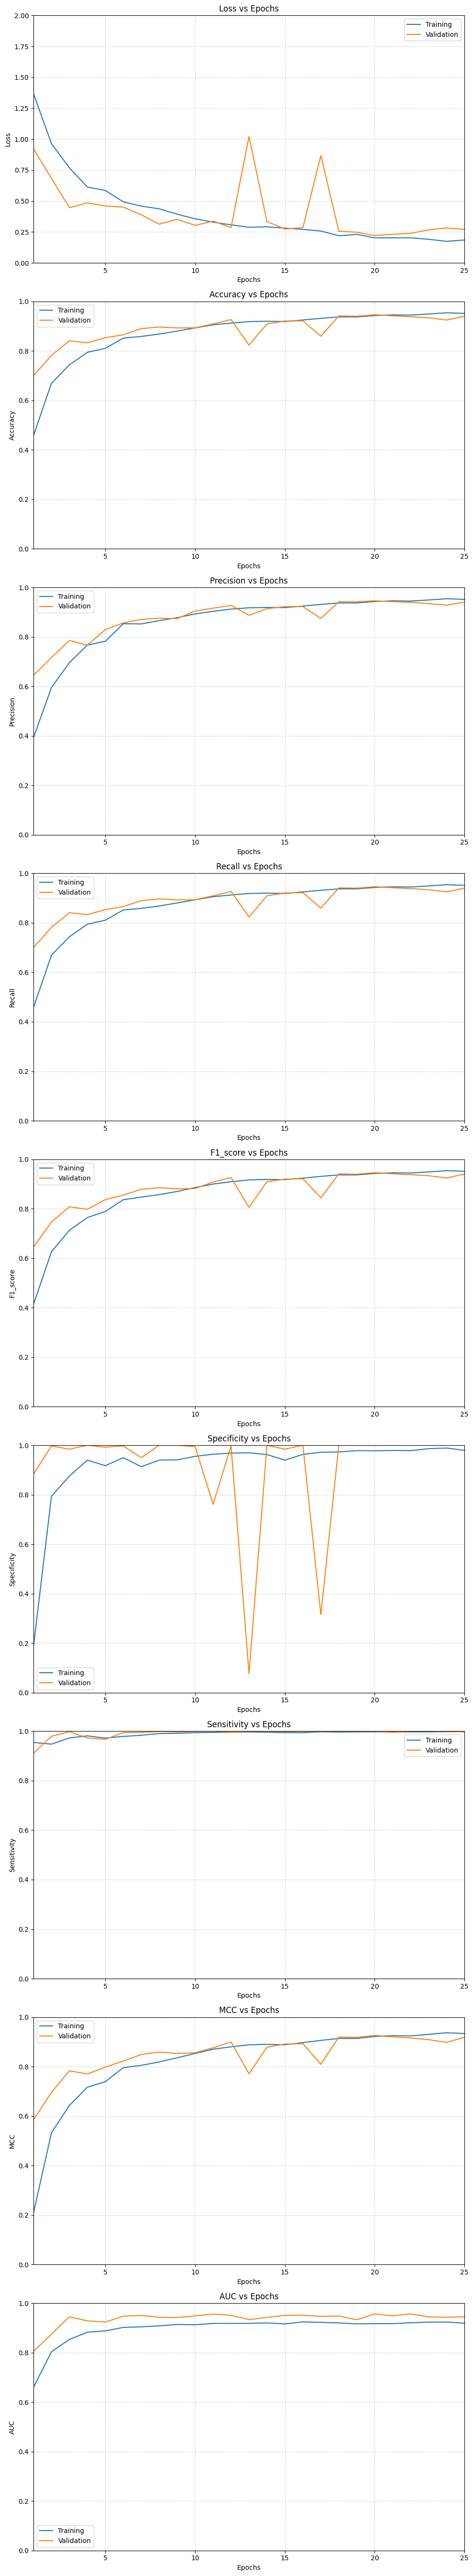

In [27]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        train_metrics_history: a dictionary containing training metrics history
        val_metrics_history: a dictionary containing validation metrics history
        metric_names: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [28]:
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(f"{testing_metrics_line}")

Testing Model: 100%|██████████| 989/989 [00:53<00:00, 18.44it/s]

Metrics - loss: 0.2270, accuracy: 0.9470, precision: 0.9478, recall: 0.9470, f1_score: 0.9471, specificity: 1.0000, sensitivity: 0.9986, mcc: 0.9277, auc: 0.9458


In [29]:
true_labels = np.array(all_targets)

predicted_labels = np.argmax(np.array(all_predictions), axis=1)

true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)

accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                     precision    recall  f1-score   support

Bacterial Pneumonia     0.9889    1.0000    0.9944       892
              COVID     0.9862    0.9241    0.9542      1160
       Lung_Opacity     0.9046    0.9336    0.9189      1929
             Normal     0.9528    0.9443    0.9485      3269
       Tuberculosis     0.9008    0.9689    0.9336       225
    Viral Pneumonia     0.9392    0.9675    0.9531       431

           accuracy                         0.9470      7906
          macro avg     0.9454    0.9564    0.9505      7906
       weighted avg     0.9478    0.9470    0.9471      7906

There were 419 errors in 7906 tests for an accuracy of  94.70


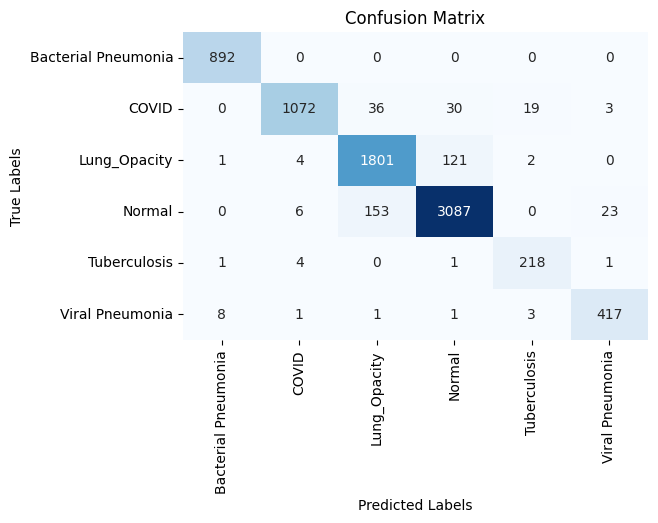

In [30]:
confusion_matrix = torch.zeros(num_classes, num_classes)
for t, p in zip(true_labels, predicted_labels):
    confusion_matrix[t, p] += 1

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()